# Image and DNA cross-attention for zero shot insect classification
#### Authors: Boscolo Meneguolo Francesco, Maritan Nicola, Sgaravatto Maria

In [ ]:
!wget -nc https://dataworks.indianapolis.iu.edu/bitstream/handle/11243/41/data.zip
!unzip -nq data.zip

# Imports and device settings

In [ ]:
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from functools import reduce

torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Dataset definition

## Test set
- Number of samples: 13428.
- Number of seen species of the training and validation set in the test set: 770.
- Number of unseen species in the test set: 134

In [ ]:
class ImageDNATestDataset(Dataset):
    def __init__(self, train=True):
        splits_mat = scipy.io.loadmat("data/INSECTS/splits.mat")
        train_loc = splits_mat["train_loc"]-1
        trainval_loc = splits_mat["trainval_loc"]-1
        test_seen_loc = splits_mat["test_seen_loc"]-1
        test_unseen_loc = splits_mat["test_unseen_loc"]-1
        val_seen_loc = splits_mat["val_seen_loc"]-1
        val_unseen_loc = splits_mat["val_unseen_loc"]-1

        TRAINING_SPECIES_NUMBER = 652
        TRAINING_VALIDATION_SPECIES = 797
        NUMBER_OF_SPECIES = 1040
        TEST_SEEN_SPECIES_NUMBER = 770
        TEST_UNSEEN_SPECIES_GENERA_NUMBER = 134

        indeces = np.concatenate((test_seen_loc, test_unseen_loc), axis=1)
        # indeces.shape is (1, |indeces|), so we extract the whole list using [0]
        indeces = indeces[0]

        data_mat = scipy.io.loadmat("data/INSECTS/data.mat")
        self.embeddings_img = torch.from_numpy(data_mat["embeddings_img"][indeces]).float()
        self.embeddings_dna = torch.from_numpy(data_mat["embeddings_dna"][indeces]).float()

        # Remap seen species in [0, 651]
        seen_species = data_mat["labels"][train_loc][0]
        seen_species_mapping = {label: i for i, label in enumerate(np.unique(seen_species))}

        # Remap unseen species during validation in [652, 796]
        unseen_species_validation = data_mat["labels"][val_unseen_loc][0]
        unseen_species_validation_mapping = {label: i + TRAINING_SPECIES_NUMBER for i, label in enumerate(np.unique(unseen_species_validation))}

        # Remap unseen species during test in [797, 1039]
        unseen_species_test = data_mat["labels"][test_unseen_loc][0]
        unseen_species_test_mapping = {label: i + TRAINING_VALIDATION_SPECIES for i, label in enumerate(np.unique(unseen_species_test))}

        assert reduce(np.intersect1d, (seen_species, unseen_species_validation, unseen_species_test)).size == 0

        # Union of the two mappings, allows to full remap all the labels
        labels_mapping = seen_species_mapping | unseen_species_validation_mapping | unseen_species_test_mapping
        assert len(labels_mapping) == NUMBER_OF_SPECIES

        species = data_mat["labels"][indeces]
        remapped_labels = np.array([labels_mapping[label.item()] for label in species])
        self.remapped_labels = torch.from_numpy(remapped_labels).long()

        # data_mat['G'] returns a ndarray of type uint16, therefore we convert into int16 before invoking from_numpy
        self.G = torch.from_numpy(data_mat["G"].astype(np.int16)).long()
        self.genera = torch.empty(species.shape).long()
        for i in range(indeces.size):
            self.genera[i][0] = self.G[species[i][0] - 1][0] - 1041

        # Compute genera of unseen species
        unseen_species_genera = []
        for i in test_unseen_loc[0]:
            unseen_species_genera.append(data_mat["G"][data_mat["labels"][i][0] - 1][0] - 1041)

        self.unseen_species_genera = np.array(unseen_species_genera)
        assert len(np.unique(self.unseen_species_genera)) == TEST_UNSEEN_SPECIES_GENERA_NUMBER

        # Compute seen species
        seen_species = []
        for i in test_seen_loc[0]:
            seen_species.append(labels_mapping[data_mat["labels"][i].item()])
        self.seen_species = np.array(seen_species)
        assert len(np.unique(self.seen_species)) == TEST_SEEN_SPECIES_NUMBER

        self.species_name = data_mat["species"][indeces]
        self.ids = data_mat["ids"][indeces]

    def __len__(self):
        return len(self.embeddings_dna)

    def __getitem__(self, idx):
        embedding_img = self.embeddings_img[idx]
        embedding_dna = self.embeddings_dna[idx]
        label = self.remapped_labels[idx].item()
        genera = self.genera[idx].item()

        return embedding_img.view(1, -1), embedding_dna.view(1, -1), label, genera

    def get_species_name(self, species):
        for idx in range(len(self.remapped_labels)):
            if self.remapped_labels[idx].item() == species:
                return self.species_name[idx].item()[0]
        return None
    def get_genera_name(self, genera):
        for idx in range(len(self.genera)):
            if self.genera[idx].item() == genera:
                return self.species_name[idx].item()[0].split()[0]
        return None

In [ ]:
class ImageDNACrossAttentionNet(nn.Module):
        def __init__(self, num_seen_species, num_genera):
                super(ImageDNACrossAttentionNet, self).__init__()
                self.fc_img = nn.Linear(2048, 512)
                self.fc_dna = nn.Linear(500, 512)
                self.img_dna_encoder_1 = ImageDNASlimEncoder(512, 2)
                self.img_dna_encoder_2 = ImageDNASlimEncoder(512, 2)
                self.fc_species = nn.Linear(1024, num_seen_species)
                self.fc_genera = nn.Linear(1024, num_genera)

        def forward(self, x_img, x_dna):
                x_img = self.fc_img(x_img)
                x_dna = self.fc_dna(x_dna)

                x_img, x_dna = self.img_dna_encoder_1(x_img, x_dna)
                x_img, x_dna = F.gelu(x_img), F.gelu(x_dna)
                x_img, x_dna = self.img_dna_encoder_2(x_img, x_dna)

                x = torch.cat((x_img, x_dna), axis=2)
                x = torch.squeeze(x, dim=1)
                x_species = self.fc_species(x)
                x_genera = self.fc_genera(x)

                return x_species, x_genera

class ImageDNASlimEncoder(nn.Module):
        def __init__(self, embed_dim, num_heads):
                super(ImageDNASlimEncoder, self).__init__()
                self.multi_head_img = nn.MultiheadAttention(embed_dim, num_heads)
                self.multi_head_dna = nn.MultiheadAttention(embed_dim, num_heads)
                self.norm_img = nn.LayerNorm(embed_dim)
                self.norm_dna = nn.LayerNorm(embed_dim)

        def forward(self, x_img, x_dna):
                identity = x_img
                x_img_out, _ = self.multi_head_img(x_img, x_dna, x_dna)
                x_img_out = self.norm_img(x_img_out + identity)

                identity = x_dna
                x_dna_out, _ = self.multi_head_dna(x_dna, x_img, x_img)
                x_dna_out = self.norm_dna(x_dna_out + identity)

                return x_img_out, x_dna_out

# Test

In [ ]:
test_set = ImageDNATestDataset()

Returns the described test accuracy by species and the undescribed validation accuracy by genus.

In [ ]:
def test(model, threshold, batch_size):
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
    model.eval()

    with torch.no_grad():
        correct_predictions_per_species = defaultdict(int)
        total_samples_per_species = defaultdict(int)
        correct_predictions_per_genera = defaultdict(int)
        total_samples_per_genera = defaultdict(int)

        for data in test_loader:
            inputs_img, inputs_dna, species, genera = data
            inputs_img, inputs_dna, species, genera = inputs_img.to(device), inputs_dna.to(device), species.to(device), genera.to(device)

            species_outputs, genera_outputs = model(inputs_img, inputs_dna)

            species_outputs = nn.Softmax(dim=1)(species_outputs)
            genera_outputs = nn.Softmax(dim=1)(genera_outputs)

            predicted_species_values, predicted_species = torch.topk(species_outputs.data, k=2, dim=1)
            _, predicted_genera = torch.max(genera_outputs.data, 1)

            differences = predicted_species_values[:, 0] - predicted_species_values[:, 1]
            genera_mask = differences <= threshold
            species_mask = ~genera_mask

            # Update relative frequencies
            for idx in range(len(genera)):
                total_samples_per_species[species[idx].item()] += 1

                if species_mask[idx] and predicted_species[idx, 0] == species[idx]:
                    correct_predictions_per_species[species[idx].item()] += 1

                # if the sample is of one undescribed species
                if species[idx].item() not in np.unique(test_set.seen_species):
                    assert genera[idx].item() in np.unique(test_set.unseen_species_genera)
                    total_samples_per_genera[genera[idx].item()] += 1

                    if genera_mask[idx] and predicted_genera[idx] == genera[idx]:
                        correct_predictions_per_genera[genera[idx].item()] += 1

        accuracy_per_species = {label: (correct_predictions_per_species[label] / total_samples_per_species[label]) if total_samples_per_species[label] > 0 else 0 for label in total_samples_per_species}
        accuracy_per_genera = {genera: (correct_predictions_per_genera[genera] / total_samples_per_genera[genera]) if total_samples_per_genera[genera] > 0 else 0 for genera in total_samples_per_genera}

        test_described_species_accuracy = 0
        for label in np.unique(test_set.seen_species):
            test_described_species_accuracy += accuracy_per_species[label]

        test_undescribed_species_accuracy = 0
        for genera in np.unique(test_set.unseen_species_genera):
            test_undescribed_species_accuracy += accuracy_per_genera[genera]

        normalized_test_described_species_accuracy = test_described_species_accuracy / 770
        normalized_test_undescribed_species_accuracy = test_undescribed_species_accuracy / 134

        return normalized_test_described_species_accuracy, normalized_test_undescribed_species_accuracy, accuracy_per_species, accuracy_per_genera

## Load final model

In [ ]:
FINAL_MODEL = "final_model.pth"
model = ImageDNACrossAttentionNet(797, 368)
model.to(device)
state_dict = torch.load(FINAL_MODEL)
model.load_state_dict(state_dict, strict=False)

## Results

In [ ]:
def show_accuracy_per_species(accuracy_per_species):
    species_names = []
    accuracies = []

    for species in accuracy_per_species:
        if species in np.unique(test_set.seen_species):
            species_names.append(test_set.get_species_name(species))
            accuracies.append(accuracy_per_species[species])

    assert len(species_names) == 770
    plt.figure(figsize=(10, 60))
    plt.barh(species_names, accuracies, color='skyblue', align='edge')
    plt.yticks(fontsize=7)
    plt.tight_layout()
    plt.xlabel('Accuracy')
    plt.ylabel('Species')
    plt.title('Accuracy per Species')
    plt.grid(axis='x')
    plt.show()

In [ ]:
def show_accuracy_per_genus(accuracy_per_genus):
    genera_names = []
    accuracies = []

    for genus in accuracy_per_genus:
        if genus in np.unique(test_set.unseen_species_genera):
            genera_names.append(test_set.get_genera_name(genus))
            accuracies.append(accuracy_per_genus[genus])

    assert len(genera_names) == 134
    plt.figure(figsize=(10, 22))
    plt.barh(genera_names, accuracies, color='orange', align='edge')
    plt.xlabel('Accuracy')
    plt.ylabel('Genus')
    plt.tight_layout()
    plt.title('Accuracy per Genus')
    plt.grid(axis='x')
    plt.show()

In [ ]:
species_accuracy, genera_accuracy, accuracy_per_species, accuracy_per_genus = test(model, best_threshold, batch_size)

print(f"Final model described species accuracy: ", species_accuracy)
print(f"Final model undescribed species accuracy: ", genera_accuracy)

Final model described species accuracy:  0.9854051296827271
Final model undescribed species accuracy:  0.76520364956048


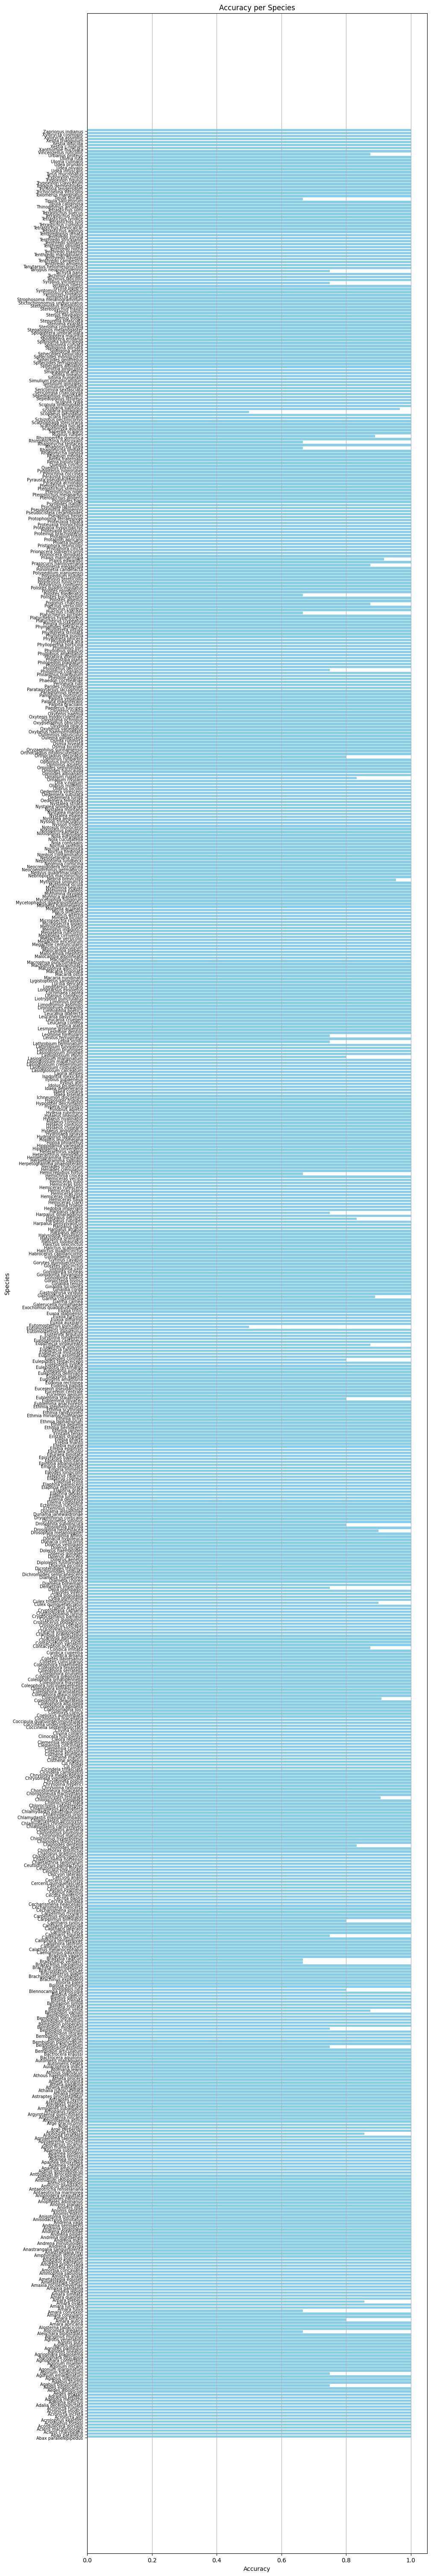

In [ ]:
show_accuracy_per_species(accuracy_per_species)

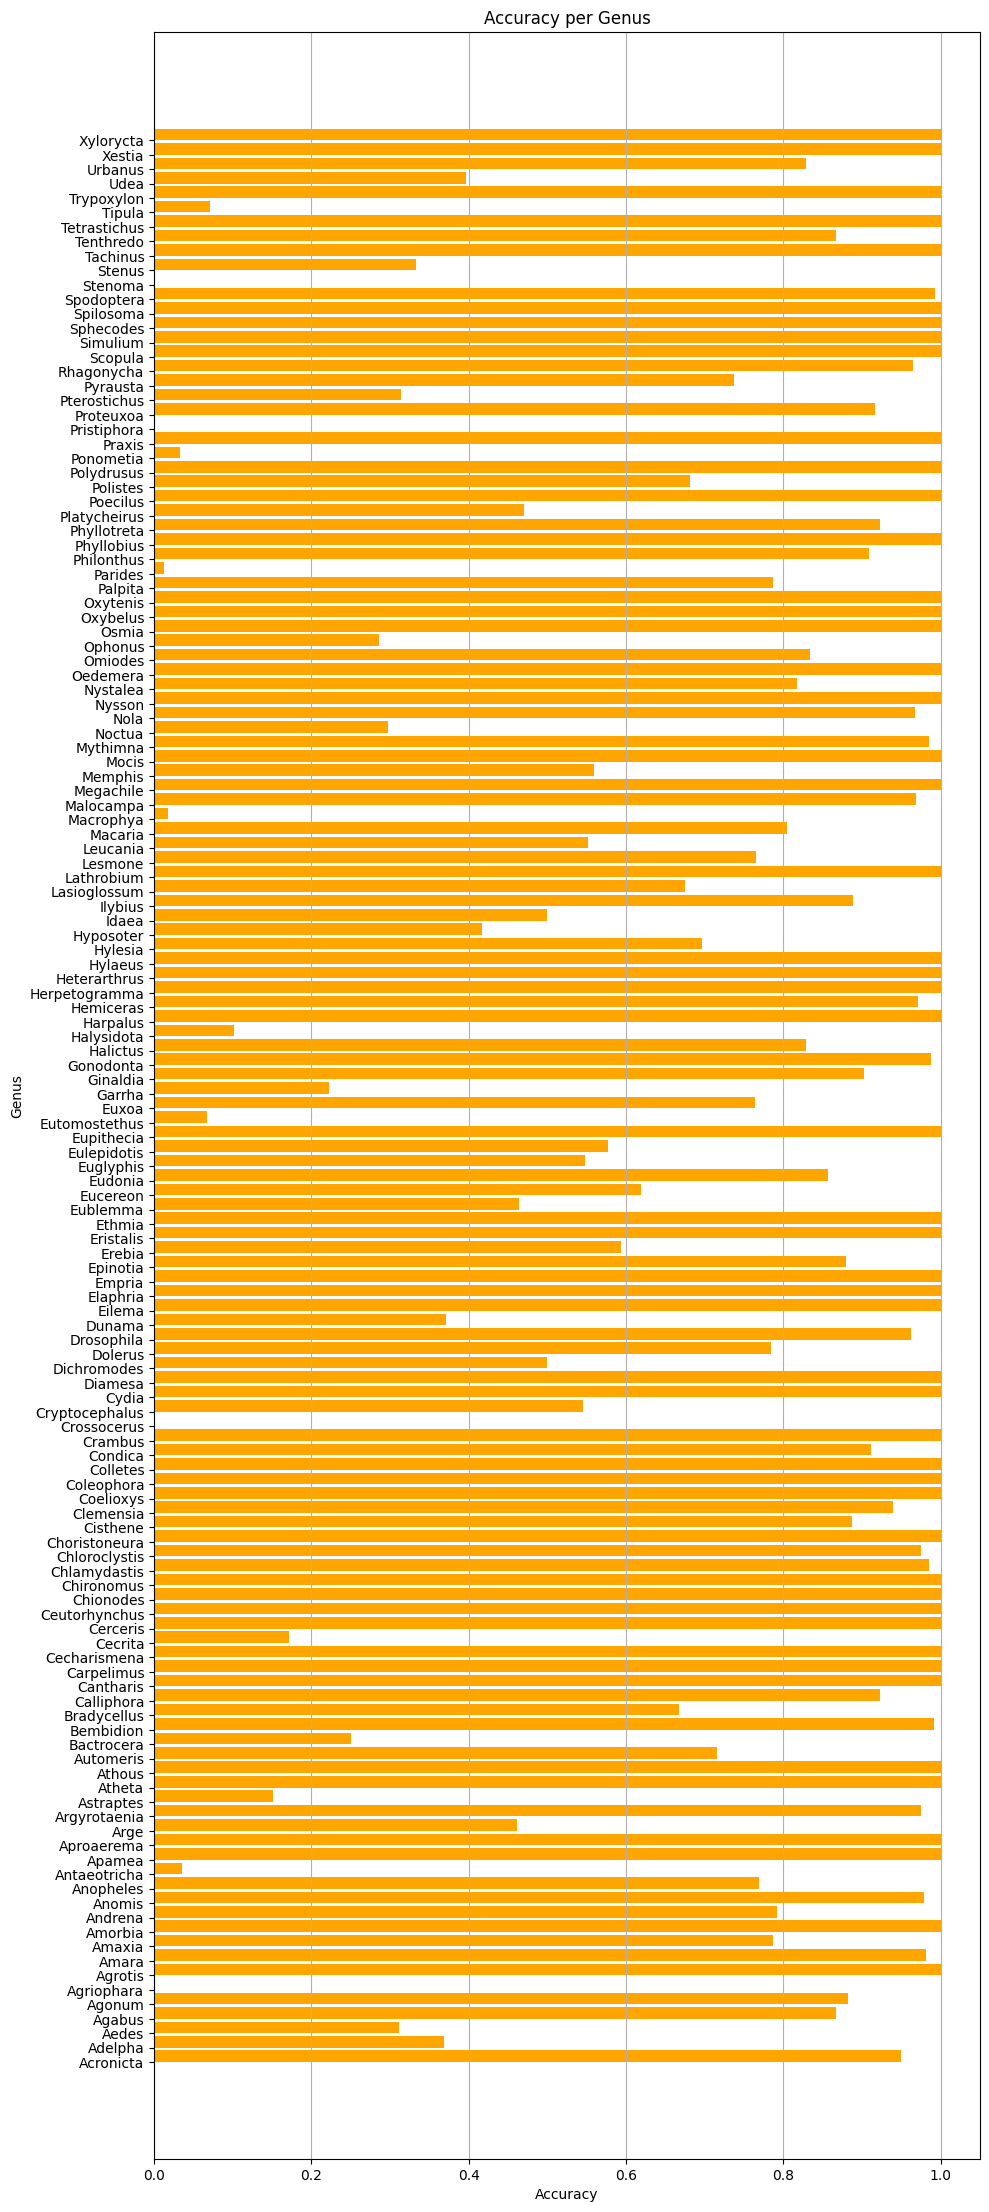

In [ ]:
show_accuracy_per_genus(accuracy_per_genus)

Compute the accuracies for different thresholds.

In [ ]:
species_accuracies = []
genus_accuracies = []

# Condense threshold values near 1 for the plot
linear_space = np.linspace(0, 1, 40)
condensed_space = 1 - (1 - linear_space) ** 3
threshold_values = 0.9 + 0.1 * condensed_space

for threshold in threshold_values:
    species_accuracy_threshold, genus_accuracy_threshold, _, _ = test(model, threshold, batch_size)
    species_accuracies.append(species_accuracy_threshold)
    genus_accuracies.append(genus_accuracy_threshold)

Plot the Species Accuracy - Genus Accuracy curve.

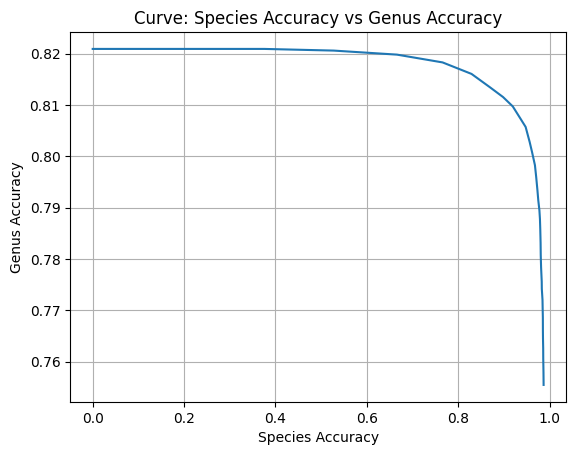

In [ ]:
plt.plot(species_accuracies, genus_accuracies, marker=' ')
plt.xlabel('Species Accuracy')
plt.ylabel('Genus Accuracy')
plt.title('Curve: Species Accuracy vs Genus Accuracy')
plt.grid(True)
plt.show()

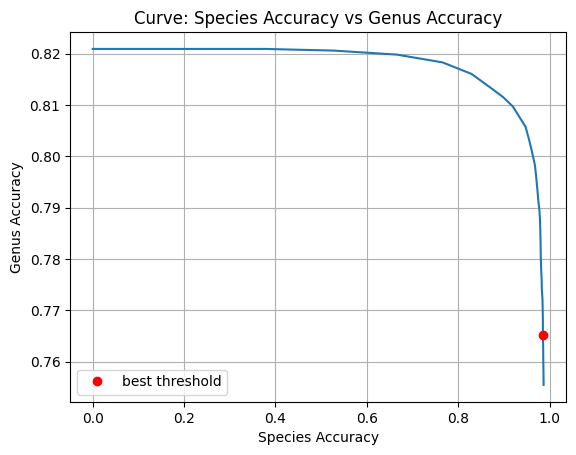

In [ ]:
plt.plot(species_accuracies, genus_accuracies, marker=' ')
plt.plot(species_accuracy, genera_accuracy,'ro', label='best threshold')
plt.legend(loc="lower left")
plt.xlabel('Species Accuracy')
plt.ylabel('Genus Accuracy')
plt.title('Curve: Species Accuracy vs Genus Accuracy')
plt.grid(True)
plt.show()

We compute the described species accuracy by species and the undescibed species accuracy by genera by predicting only species (threshold = 0) and only genus, respectively (threshold = 1).
In this case, we suppose that an oracle divides the insect between those with known species and those only with known genus.

In [ ]:
only_species_accuracy, _, only_accuracy_per_species, _ = test(model, 0, batch_size)
_, only_genera_accuracy, _, only_accuracy_per_genus = test(model, 1, batch_size)

print(f"Final model only described species accuracy: ", only_species_accuracy)
print(f"Final model only undescribed species accuracy: ", only_genera_accuracy)

Final model only described species accuracy:  0.9947745310245308
Final model only undescribed species accuracy:  0.8209434759540032


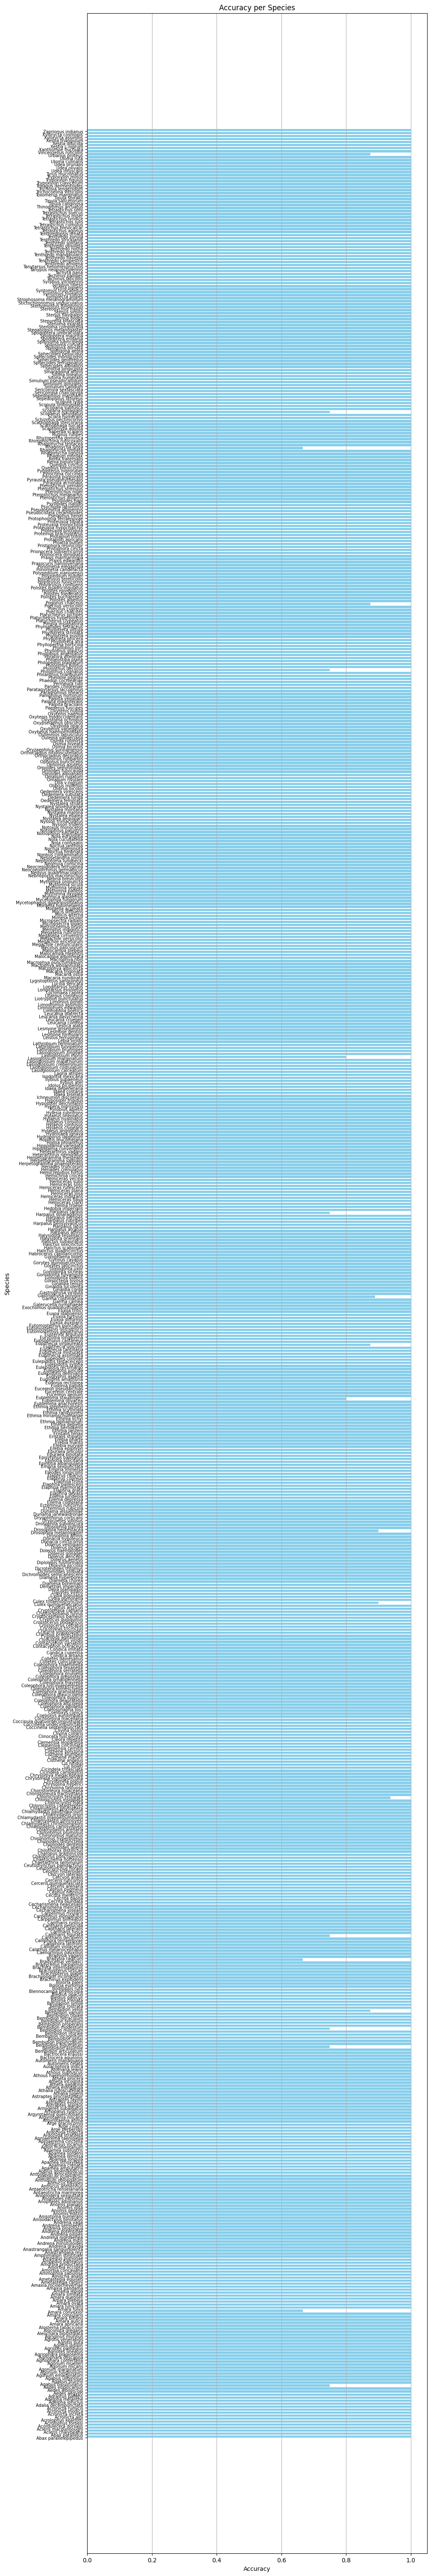

In [ ]:
show_accuracy_per_species(only_accuracy_per_species)

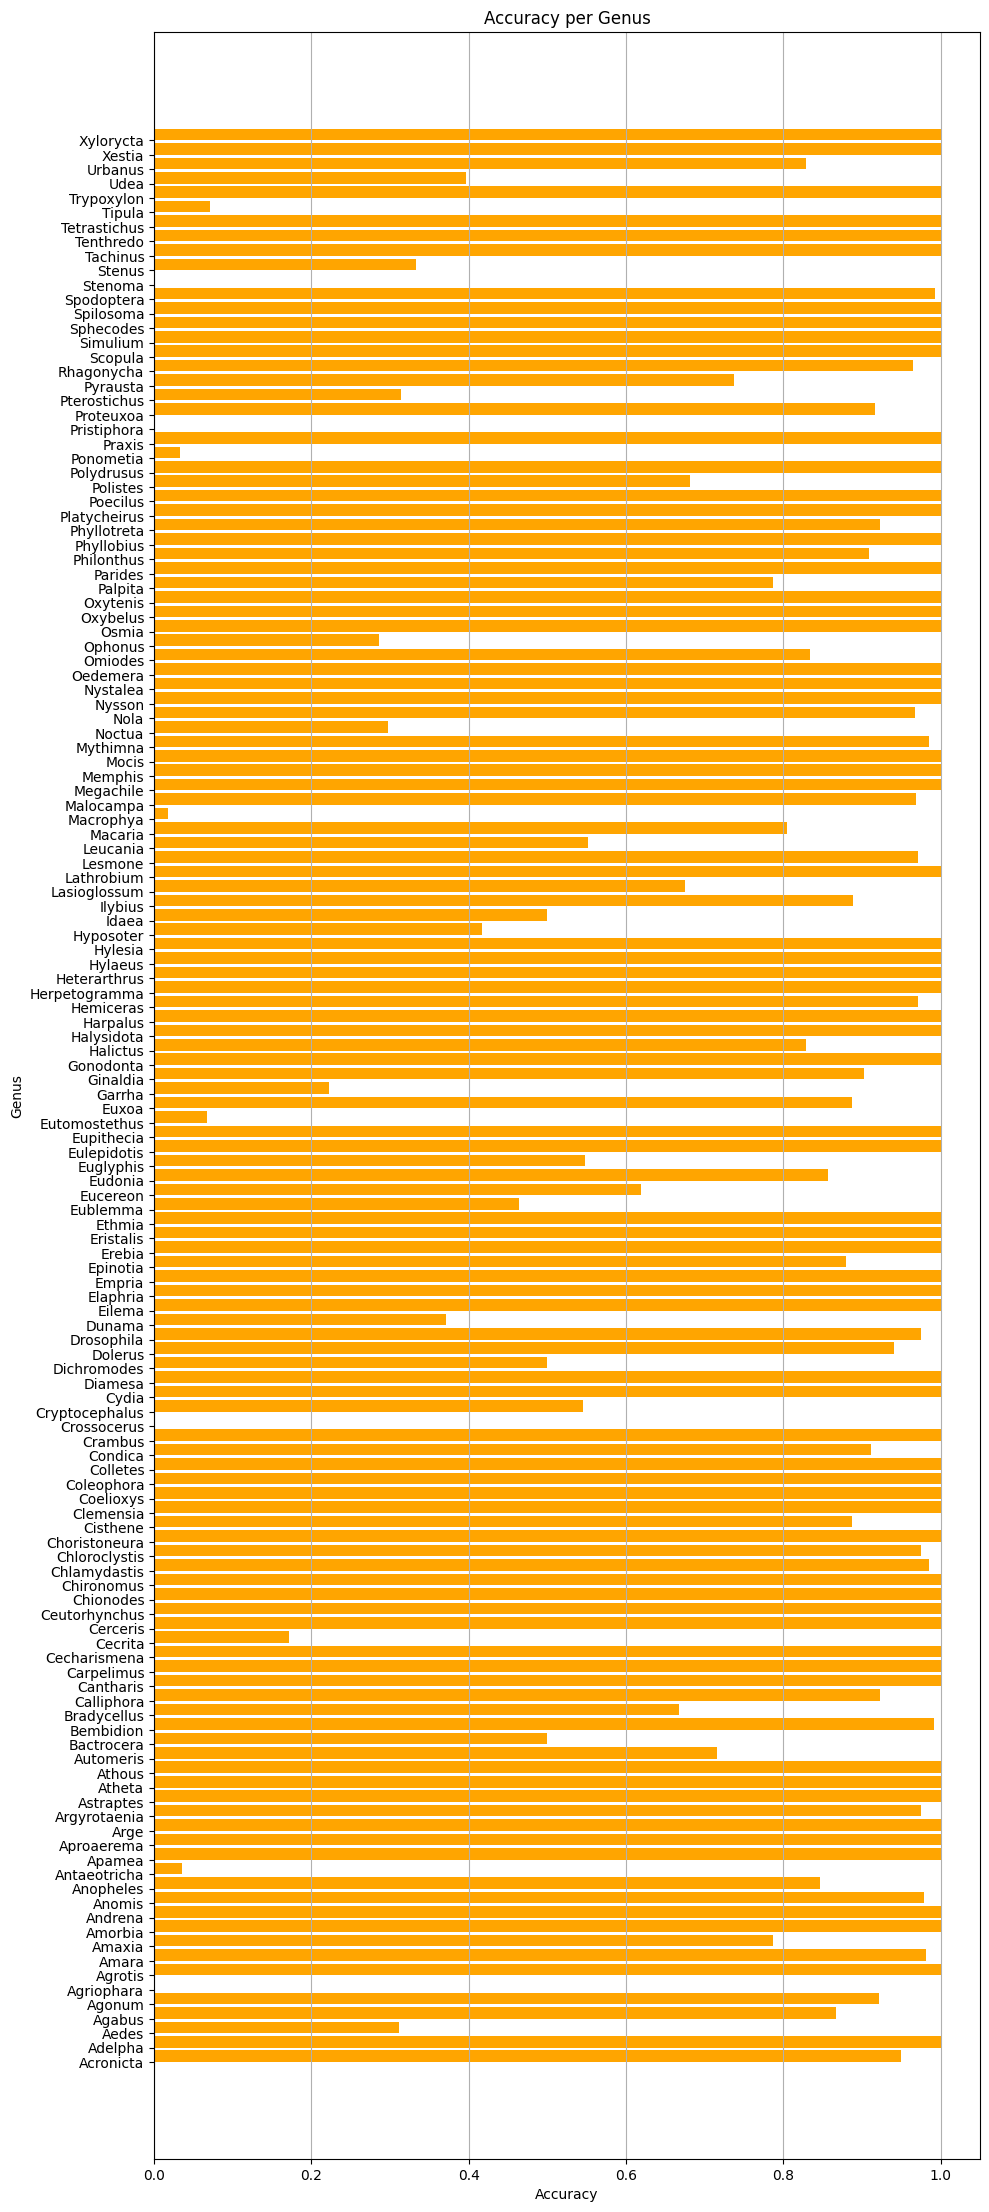

In [ ]:
show_accuracy_per_genus(only_accuracy_per_genus)